In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import sklearn

In [4]:
train_x = []
train_y = []
count = 0
with open('CIKM2017_train/train.txt') as fhdl:
    for line in fhdl:
        count += 1
        if count % 50 == 0:
            print (float(count) / 10000,end=' '),
        linenum,label,datas = line.strip().split(',')
        label = float(label)
        datas = np.asarray(datas.split(' '),dtype=np.int8)
        train_x.append(datas)
        train_y.append(label)

0.005 0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 0.255 0.26 0.265 0.27 0.275 0.28 0.285 0.29 0.295 0.3 0.305 0.31 0.315 0.32 0.325 0.33 0.335 0.34 0.345 0.35 0.355 0.36 0.365 0.37 0.375 0.38 0.385 0.39 0.395 0.4 0.405 0.41 0.415 0.42 0.425 0.43 0.435 0.44 0.445 0.45 0.455 0.46 0.465 0.47 0.475 0.48 0.485 0.49 0.495 0.5 0.505 0.51 0.515 0.52 0.525 0.53 0.535 0.54 0.545 0.55 0.555 0.56 0.565 0.57 0.575 0.58 0.585 0.59 0.595 0.6 0.605 0.61 0.615 0.62 0.625 0.63 0.635 0.64 0.645 0.65 0.655 0.66 0.665 0.67 0.675 0.68 0.685 0.69 0.695 0.7 0.705 0.71 0.715 0.72 0.725 0.73 0.735 0.74 0.745 0.75 0.755 0.76 0.765 0.77 0.775 0.78 0.785 0.79 0.795 0.8 0.805 0.81 0.815 0.82 0.825 0.83 0.835 0.84 0.845 0.85 0.855 0.86 0.865 0.87 0.875 0.88 0.885 0.89 0.895 0.9 0.905 0.91 0.915 0.

In [3]:
import pickle
train_x,train_y = pickle.load(open('data.pkl','rb'))

In [4]:
len(train_x),len(train_y)

(10000, 10000)

In [5]:
from sklearn.cross_validation import train_test_split
train_x,test_x,train_y,test_y = train_test_split(train_x,train_y,test_size=0.2,random_state=1123)

In [6]:
# do not use this now, will cause future shuffle slow
#train_x = np.asarray(train_x,dtype=np.int8)
test_x = np.asarray(test_x,dtype=np.int8)

In [7]:
len(train_x),len(train_y),test_x.shape,len(test_y)

(8000, 8000, (2000, 612060), 2000)

In [8]:
from sklearn.utils import shuffle
#train_x,train_y = shuffle(train_x,train_y)

In [ ]:
import pickle
#pickle.dump((train_x,train_y),open('data.pkl','wb'))

In [8]:
import sys
sys.getsizeof(train_x[0]) * 10000

960000

In [8]:
sample = np.asarray([-2,2],dtype=np.int8)

In [9]:
sample[sample < 0] = 0
sample

array([0, 2], dtype=int8)

In [9]:
# process negative value
for each_ele in train_x:
    each_ele[each_ele < 0] = 0
test_x[test_x < 0] = 0

In [10]:
len(train_x),test_x.shape

(8000, (2000, 612060))

In [12]:
# TODO use 100% data ,not 80% now

weights_dic = {}

from sklearn.utils import shuffle
feed_size = 100
n_input = 101 * 101 * 60
X = tf.placeholder(tf.int8,[None,n_input])
W = tf.Variable(tf.zeros([n_input,1]),tf.float32)
b = tf.Variable([0.0],tf.float32)
y = tf.add(tf.matmul(tf.to_float(X),W),b)
y_ = tf.placeholder(tf.float32)
resm = tf.reduce_sum(tf.pow(tf.transpose(y) - y_,2))

val_train_size = 1000

train_resm = tf.sqrt(tf.div(tf.reduce_sum(tf.pow(tf.transpose(y) - y_,2)), val_train_size))
real_resm = tf.sqrt(tf.div(tf.reduce_sum(tf.pow(tf.transpose(y) - y_,2)), len(test_y)))
debug_var = tf.transpose(y) - y_

train_step = tf.train.AdamOptimizer(0.0000003).minimize(resm)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for i in range(4000):
    indexbegin = feed_size * i % len(train_y)
    if i % (len(train_y) / (feed_size)) == 0:
        print("shuffleing ...")
        train_x,train_y = shuffle(train_x,train_y)
    batch_xs,batch_ys = np.asarray(train_x[indexbegin:indexbegin + feed_size],dtype=np.int8),train_y[indexbegin:indexbegin + feed_size]
    if i % (len(train_y) / (feed_size * 2)) == 0:
        print('itertion %s' % (i),end=' ')
        curr_loss = sess.run(train_resm,feed_dict={X:train_x[:val_train_size],y_:train_y[:val_train_size]})
        print ("train loss: %s" % (curr_loss),end=' ')
        curr_loss = sess.run(real_resm,feed_dict={X:test_x,y_:test_y})
        print ("test loss: %s" % (curr_loss),end=" ")
        print(" check weights_dic[%s]" % (i),end=" ")
        yy = sess.run(y,feed_dict={X:test_x})
        print (yy[:10,0])
        debug_val = sess.run(debug_var,feed_dict={X:test_x,y_:test_y})
        weights_dic[i] = (sess.run(W),sess.run(b),yy,debug_val)
    sess.run(train_step,feed_dict={X:batch_xs,y_:batch_ys})

Instructions for updating:
Use `tf.global_variables_initializer` instead.
shuffleing ...
itertion 0 train loss: 23.314 test loss: 22.2155  check weights_dic[0] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
itertion 40 train loss: 18.3213 test loss: 17.4854  check weights_dic[40] [ 12.58865261   9.82677078  10.96589184   4.07967043   6.3548398
   6.24123335   8.49040222   6.04288816   9.95133114  10.71684456]
shuffleing ...
itertion 80 train loss: 17.1917 test loss: 16.9263  check weights_dic[80] [ 20.98364067  14.27559376  18.14370537   8.85242081  10.64202881
   9.83480549  12.17229271   8.78020287  12.32275009  16.65918159]
itertion 120 train loss: 16.8889 test loss: 16.6531  check weights_dic[120] [ 16.26880074  12.98108101  16.50458717   8.79149437   9.68569565
  11.03188992  12.37869358   8.93195057   9.81416035   9.28127193]
shuffleing ...
itertion 160 train loss: 16.7551 test loss: 16.456  check weights_dic[160] [ 22.00974655  17.65743637  21.0951786   11.68051243  13.00244045
  13.

KeyboardInterrupt: 

In [21]:
import pickle
with open('data/4_12_tf_linear_adam_80_precent_weight.plk','wb') as whdl:
    pickle.dump(weights_dic,whdl)

In [ ]:
import pickle
with open('data/4_12_tf_linear_adam_80_precent_weight.plk','rb') as fhdl:
    weight_dic = pickle.load(fhdl)

In [22]:
weights_dic.keys()

dict_keys([0, 1600, 1680, 2200, 1040, 2080, 1160, 80, 2720, 2320, 2000, 840, 920, 2520, 2160, 280, 640, 2120, 2920, 800, 1520, 440, 960, 1560, 680, 2640, 2040, 760, 1280, 560, 520, 1480, 40, 1080, 2400, 2600, 320, 160, 1920, 2800, 360, 2840, 200, 1200, 2240, 2440, 720, 120, 1880, 1000, 2560, 600, 2480, 1960, 2360, 1840, 480, 1360, 240, 2880, 1800, 1640, 1120, 2680, 880, 1320, 400, 1440, 2280, 1400, 1720, 1240, 1760, 2760])

In [32]:
del train_x
del train_y
del test_x
del test_y

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0A5629AC8>]], dtype=object)

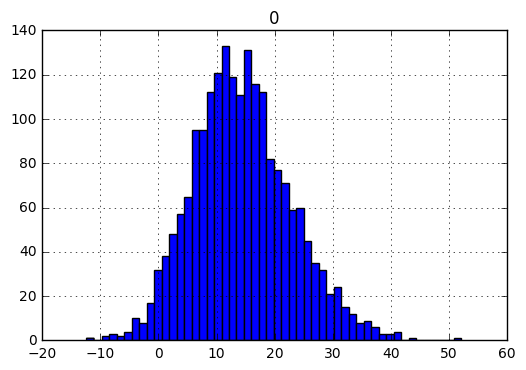

In [40]:
# virtulizing
%matplotlib inline
import pandas as pd
pd.DataFrame(weights_dic[2080][2]).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F083BA28D0>]], dtype=object)

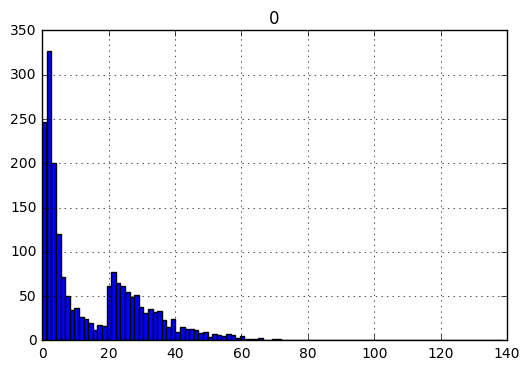

In [36]:
# virtulizing
%matplotlib inline
import pandas as pd
pd.DataFrame(test_y).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F07F9CED30>]], dtype=object)

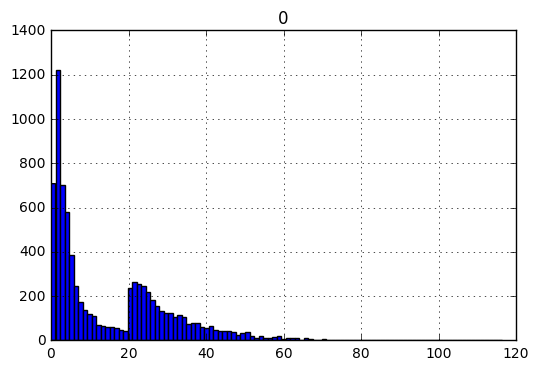

In [37]:
# virtulizing
%matplotlib inline
import pandas as pd
pd.DataFrame(train_y).hist(bins=100)

In [39]:
predict_x = []
count = 0
with open('CIKM2017_testA/testA.txt') as fhdl:
    for line in fhdl:
        count += 1
        if count % 50 == 0:
            print (float(count) / 10000,end=' '),
        linenum,label,datas = line.strip().split(',')
        label = float(label)
        datas = np.asarray(datas.split(' '),dtype=np.int8)
        predict_x.append(datas)

0.005 0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 

In [43]:
with open('onlinedata.plk','wb') as whdl:
    pickle.dump(predict_x,whdl)

In [27]:
with open('onlinedata.plk','rb') as fhdl:
    predict_x = pickle.load(fhdl)

EOFError: Ran out of input

In [44]:
predict_x = np.asarray(predict_x,dtype=np.int8)

In [45]:
predict_x[predict_x < 0] = 0

In [70]:
predict_y = sess.run(y,feed_dict={X:np.asarray(predict_x,dtype=np.int8)})

In [71]:
predict_y

array([[  7.89219189],
       [ 10.65508747],
       [ 12.67513371],
       ..., 
       [  5.09071112],
       [  2.88096619],
       [  3.77302599]], dtype=float32)

In [53]:
model_w,model_b,_,__ = weights_dic[2080]

In [58]:
mm = np.dot(np.asarray(predict_x),model_w) + model_b

In [59]:
mm[:,0]

array([ 10.17464066,  10.30313778,  10.10918713, ...,  17.9347229 ,
         4.12181139,  13.42354012], dtype=float32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0AE1760B8>]], dtype=object)

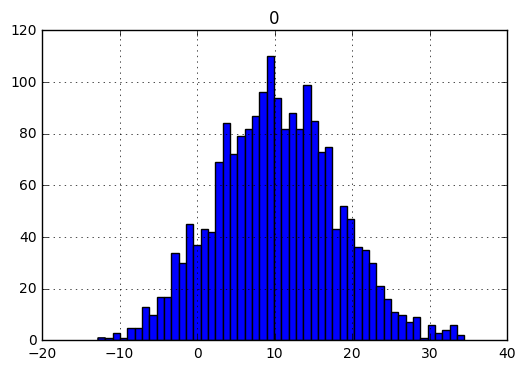

In [60]:
pd.DataFrame(mm).hist(bins=50)

In [61]:
result = mm
result[result < 0] = 0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0AE541A58>]], dtype=object)

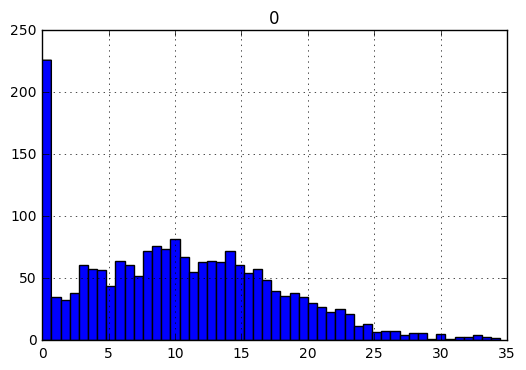

In [63]:
pd.DataFrame(result).hist(bins=50)

In [64]:
result

array([[ 10.17464066],
       [ 10.30313778],
       [ 10.10918713],
       ..., 
       [ 17.9347229 ],
       [  4.12181139],
       [ 13.42354012]], dtype=float32)

In [60]:
for itern in range(0,1000,160):
    print(itern)
    with open('answers/4_11_tf_linear_adam_80_precent_weight_iter_%s.csv' % itern,'w') as whdl:
        model_w,model_b = weights_dic[itern]
        predict_y = np.dot(np.asarray(predict_x),model_w) + model_b
        for value in predict_y[:,0]:
            whdl.write("%s\n" % (max(value,0)))
for itern in range(1000,2760,40):
    print (itern)
    with open('answers/4_11_tf_linear_adam_80_precent_weight_iter_%s.csv' % itern,'w') as whdl:
        model_w,model_b = weights_dic[itern]
        predict_y = np.dot(np.asarray(predict_x),model_w) + model_b
        for value in predict_y[:,0]:
            whdl.write("%s\n" % (max(value,0)))
        

0
160
320
480
640
800
960
1000
1040
1080
1120
1160
1200
1240
1280
1320
1360
1400
1440
1480
1520
1560
1600
1640
1680
1720
1760
1800
1840
1880
1920
1960
2000
2040
2080
2120
2160
2200
2240
2280
2320
2360
2400
2440
2480
2520
2560
2600
2640
2680
2720


In [74]:
predict_y[0][0]

7.8921919

In [75]:
with open('answer_4_11.csv','w') as whdl:
    for value in predict_y:
        whdl.write("%s\n" % (value[0]))

In [19]:
model_w,model_b,predict_yy,delta = weights_dic[80]
result = predict_yy.T
np.sqrt(np.average(np.square(result - np.array(test_y))))

16.926345488144662

In [18]:
result - np.array(test_y)

array([[  0.61534843,  -6.69326286,  17.8012188 , ...,   7.73505859,
        -43.38261251,   2.96363621]])

In [80]:
predict_yy.T

array([[ 16.83102036,  11.27466583,  14.53311634, ...,  10.99525642,
          4.09835196,  12.1026535 ]], dtype=float32)

In [83]:
predict_yy

array([[ 16.83102036],
       [ 11.27466583],
       [ 14.53311634],
       ..., 
       [ 10.99525642],
       [  4.09835196],
       [ 12.1026535 ]], dtype=float32)

In [13]:
model_w,model_b,predict_yy,delta = weights_dic[80]
np.sqrt(np.average(np.square(delta)))

16.926346

In [76]:
delta

array([[ -5.56897926, -11.5253334 ,  10.83311653, ...,   6.29525661,
        -45.20164871,   9.90265369]], dtype=float32)

In [87]:
predict_yy.T - test_y

array([[ -5.56897964, -11.52533417,  10.83311634, ...,   6.29525642,
        -45.20164804,   9.9026535 ]])

In [91]:
predict_y

array([[ 16.83102608],
       [ 11.27465439],
       [ 14.53310394],
       ..., 
       [ 10.99524212],
       [  4.0983448 ],
       [ 12.10265636]], dtype=float32)

In [14]:
model_w,model_b,predict_yy,delta = weights_dic[80]
predict_y = np.dot(np.asarray(test_x),model_w) + model_b
np.sqrt(np.average(np.square(predict_y.T - np.array(test_y))))

16.926346708934535

In [30]:
len(test_y)

2000

In [45]:
model_w,model_b = weight_dic[2000]
#result = np.dot(np.asarray(test_x),model_w) + model_b
result = np.zeros(2000)
np.sqrt(np.average(np.square(result[:,0] - np.array(test_y))))

IndexError: too many indices for array